In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.spatial.distance import pdist, squareform
from scipy.spatial.distance import directed_hausdorff
import os
import csv



In [2]:
# Load the image
img_path = "/Users/insafbenlamari/Desktop/akenes/strawberry.png"

achenes_img="/Users/insafbenlamari/Desktop/akenes/handmade_achenes.png"

In [3]:
def extract_strawberry(img_path):
    image = cv2.imread(img_path)
    image= cv2.resize(image, (500, 500))

    # Convert the image to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define lower and upper bounds for red color in HSV (for strawberries)
    lower_red = np.array([0, 120, 70])
    upper_red = np.array([10, 255, 255])

    # Threshold the HSV image to get only red colors (strawberries)
    mask = cv2.inRange(hsv_image, lower_red, upper_red)

    # Apply morphological operations (dilation and erosion) to include contiguous areas
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations=2)
    mask = cv2.erode(mask, kernel, iterations=1)

    # Find contours in the masked image
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the contour with the largest area
    largest_contour = max(contours, key=cv2.contourArea)

    # Create a mask for the largest contour
    largest_contour_mask = np.zeros_like(mask)
    area = cv2.contourArea(largest_contour)
    cv2.drawContours(largest_contour_mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

    # Bitwise AND mask with the original image
    result = cv2.bitwise_and(image, image, mask=largest_contour_mask)
    segmented=cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    # Create a white background image
    white_background = np.ones_like(image) * 255

    # Invert the largest contour mask to get the mask for the area outside the contour
    outside_contour_mask = cv2.bitwise_not(largest_contour_mask)

    # Bitwise AND the white background with the mask for the area outside the contour to set it to white
    white_background = cv2.bitwise_and(white_background, white_background, mask=outside_contour_mask)

    # Bitwise OR the white background with the extracted area
    result = cv2.bitwise_or(white_background, cv2.bitwise_and(image, image, mask=largest_contour_mask))
    result=cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    return  result,area

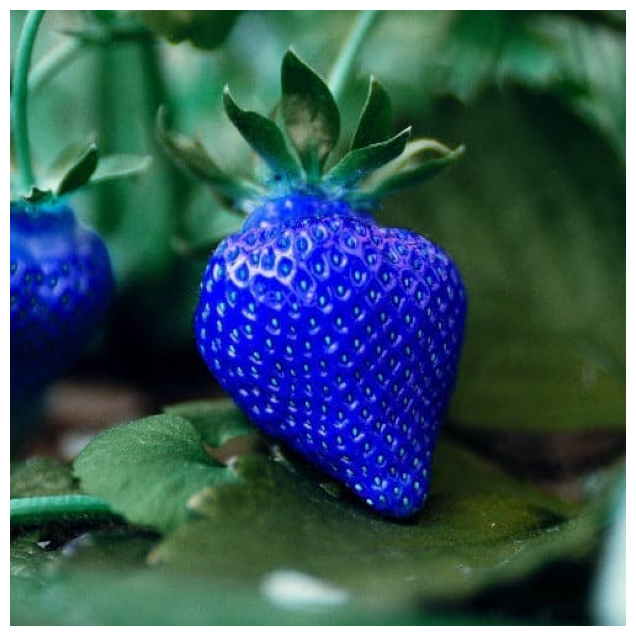

In [4]:
strawberry_no_dots ,fraise=extract_strawberry(img_path)
# Display the output
plt.figure(figsize=(10, 8))
plt.imshow(cv2.imread(img_path))
plt.axis('off')
plt.show()


In [5]:
strawberry_no_dots ,fraise=extract_strawberry(img_path)
fraise

40829.0

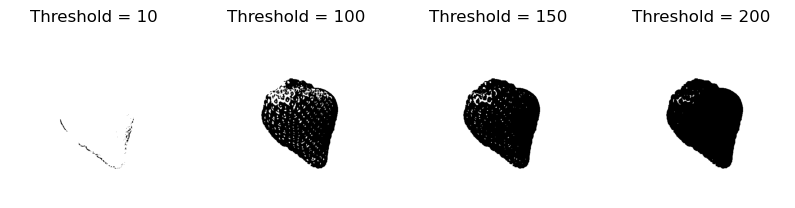

In [6]:
gray = cv2.cvtColor(strawberry_no_dots, cv2.COLOR_BGR2GRAY)
# Thresholding to separate achenes from background with different threshold values
_, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

_, thresh1 = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)
_, thresh2 = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)
_, thresh3 = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)

# Visualize the thresholded images
plt.figure(figsize=(10, 6))
plt.subplot(1, 4, 1)
plt.imshow(thresh, cmap='gray')
plt.title('Threshold = 10')
plt.axis('off')
plt.subplot(1, 4, 2)
plt.imshow(thresh1, cmap='gray')
plt.title('Threshold = 100')
plt.axis('off')
plt.subplot(1, 4, 3)
plt.imshow(thresh2, cmap='gray')
plt.title('Threshold = 150')
plt.axis('off')
plt.subplot(1, 4, 4)
plt.imshow(thresh3, cmap='gray')
plt.title('Threshold = 200')
plt.axis('off')
plt.show()


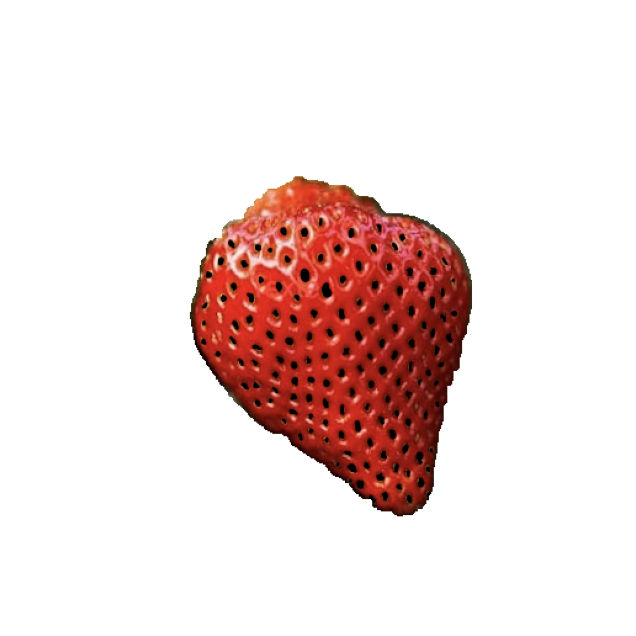

In [7]:
strawberry_akenes_a_main,fraise=extract_strawberry(achenes_img)
# Display the output
plt.figure(figsize=(10, 8))
plt.imshow(strawberry_akenes_a_main)
plt.axis('off')
plt.show()


In [8]:
def extract_akenes_sift(img_path):
    np.random.seed(0)
    segmented=np.array(extract_strawberry(img_path)[0])
    area=extract_strawberry(img_path)[1]
    # Load the image
    gray = cv2.cvtColor(segmented, cv2.COLOR_BGR2GRAY)
    image = gray  # Assuming gray is the image you want to draw on

    # Create a white background image
    white_background = np.ones_like(segmented) * 255

    equalized_image = cv2.equalizeHist(image)
    # Initialize the SIFT detector
    sift = cv2.SIFT_create(
        nfeatures=300,        # Number of keypoints to retain (0 for default)
        contrastThreshold=0.02,  # Threshold to filter weak keypoints
        edgeThreshold=20,   # Threshold to filter edge keypoints
        sigma=1.3      # Standard deviation of the Gaussian blur applied to the input image
    )

    # Detect keypoints and descriptors on the original image
    keypoints_original, descriptors_original = sift.detectAndCompute(image, None)

    # Detect keypoints and descriptors on the equalized image
    keypoints_equalized, descriptors_equalized = sift.detectAndCompute(equalized_image, None)

    # Combine the keypoints from both images
    all_keypoints = keypoints_original + keypoints_equalized
    # Define a distance threshold for merging keypoints
    distance_threshold = 7  # Adjust as needed

    # Merge keypoints that are close to each other
    merged_keypoints = []
    merged_indices = set()  # To keep track of merged keypoints
    for i, kp1 in enumerate(all_keypoints):
        if i in merged_indices:
            continue  # Skip keypoints that have already been merged
        merged_keypoint = kp1
        count = 1
        for j, kp2 in enumerate(all_keypoints[i + 1:]):
            if cv2.norm(kp1.pt, kp2.pt) < distance_threshold:
                merged_keypoint.pt = ((merged_keypoint.pt[0] * count + kp2.pt[0]) / (count + 1),
                                    (merged_keypoint.pt[1] * count + kp2.pt[1]) / (count + 1))
                merged_indices.add(i + 1 + j)  # Add the index of the merged keypoint
                count += 1
        merged_keypoints.append(merged_keypoint)

    # Draw the keypoints as dots on the original image
    output = segmented.copy()
    for kp in merged_keypoints:
        x, y = int(kp.pt[0]), int(kp.pt[1])
        cv2.circle(output, (x, y), 2, (0, 255, 0), -1) 
    coords1 = np.array([kp.pt for kp in merged_keypoints])
    return  output, coords1,area

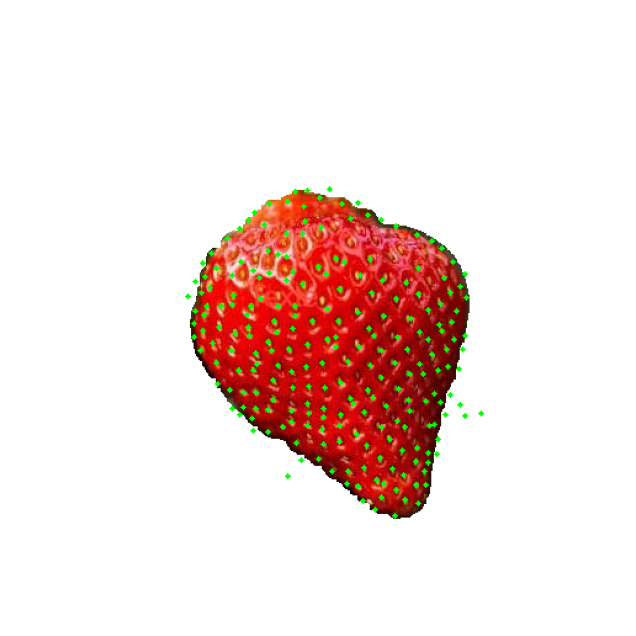

In [9]:
akenes_detecte_image,akene_sift_coords,fraise=extract_akenes_sift(img_path)
# Display the output image with keypoints
plt.figure(figsize=(10, 8))
plt.imshow(akenes_detecte_image)
plt.axis('off')
plt.show()

In [10]:
def extract_akenes_a_main(img_path):
    image,area= extract_strawberry(img_path)
    image=np.array(image)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Thresholding to separate achenes from background
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

    # Find contours around the black regions
    thresh_inverted = cv2.bitwise_not(thresh)
    contours, _ = cv2.findContours(thresh_inverted, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours on the original image
    contour_image = image.copy()
    cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

    # Extract centroid of each contour as achenes point
    achenes_points = []
    for cnt in contours:
        M = cv2.moments(cnt)
        if M['m00'] != 0:
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            achenes_points.append((cx, cy))

    # Draw the extracted points on the original image
    for point in achenes_points:
        cv2.circle(contour_image, point, 2, (0, 0, 0), -1)

    
    return  contour_image,achenes_points,area
    

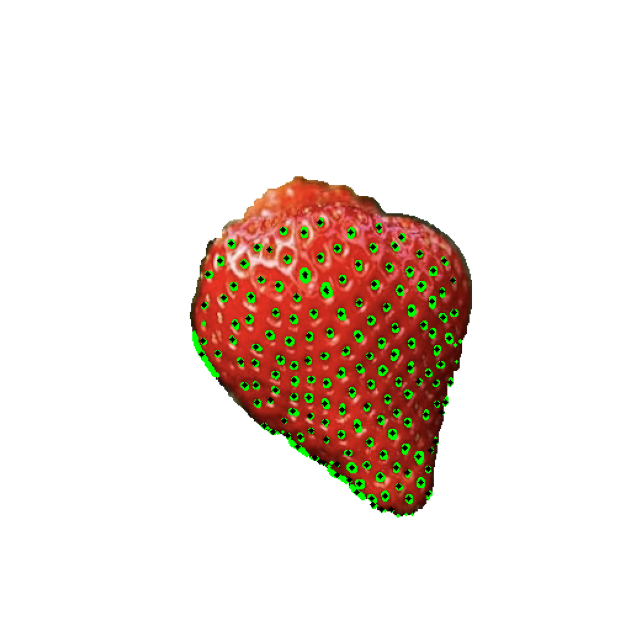

In [11]:
image_akenes_centre,akenes_coords,fraise=extract_akenes_a_main(achenes_img)
# Display the image with contours and points
plt.figure(figsize=(10, 8))
plt.imshow(image_akenes_centre)
plt.axis('off')
plt.show()



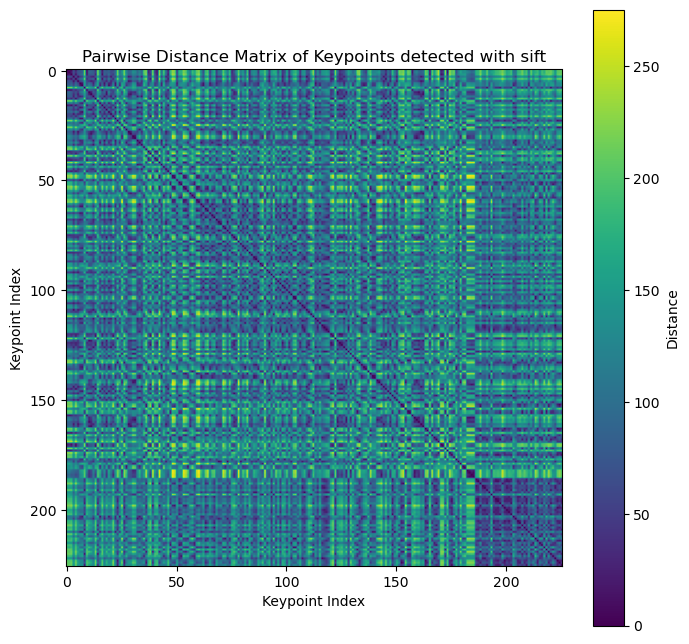

In [12]:
# Extract keypoints coordinates
keypoint_coords = np.array(akene_sift_coords)

# Calculate pairwise distances between keypoints
dist_matrix = squareform(pdist(keypoint_coords))

# Plot spatial distribution of pairwise distances
plt.figure(figsize=(8, 8))
plt.imshow(dist_matrix, cmap='viridis')
plt.colorbar(label='Distance')
plt.title('Pairwise Distance Matrix of Keypoints detected with sift')
plt.xlabel('Keypoint Index')
plt.ylabel('Keypoint Index')
plt.show()


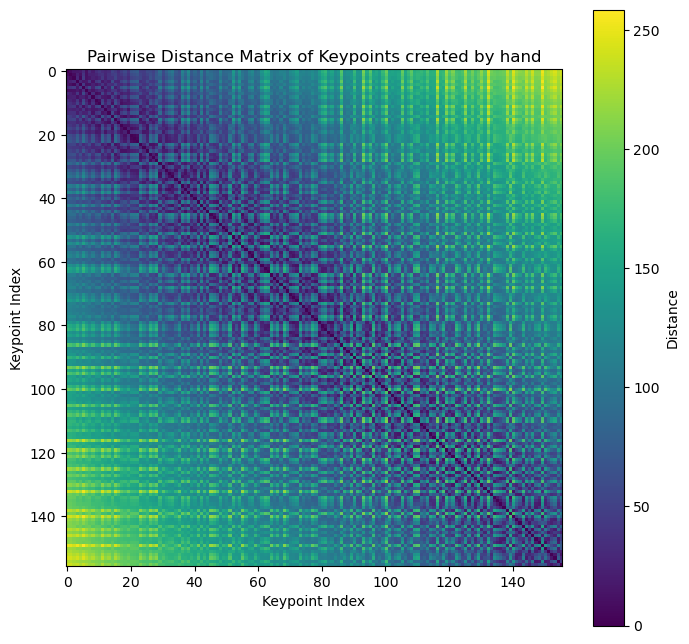

In [13]:
# Extract keypoints coordinates
keypoint_coords = np.array(akenes_coords)

# Calculate pairwise distances between keypoints
dist_matrix = squareform(pdist(keypoint_coords))

# Plot spatial distribution of pairwise distances
plt.figure(figsize=(8, 8))
plt.imshow(dist_matrix, cmap='viridis')
plt.colorbar(label='Distance')
plt.title('Pairwise Distance Matrix of Keypoints created by hand')
plt.xlabel('Keypoint Index')
plt.ylabel('Keypoint Index')
plt.show()


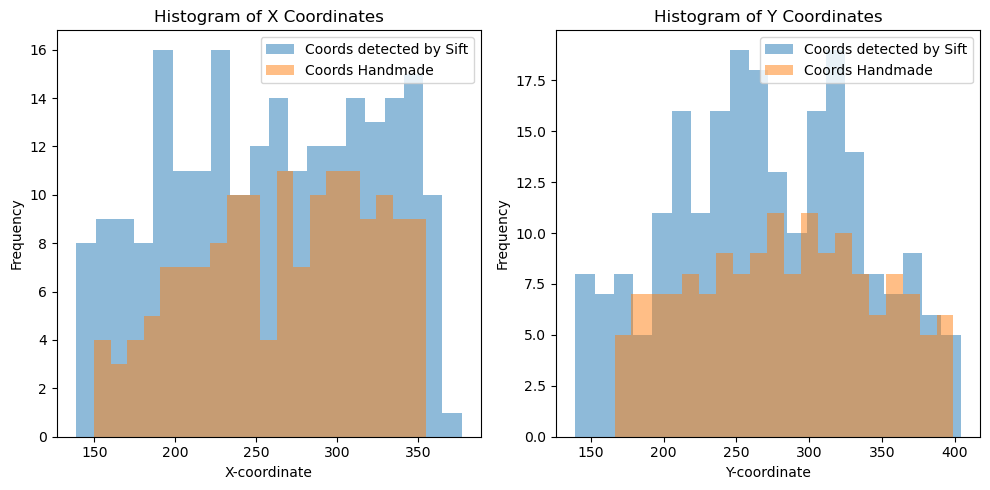

In [14]:
akenes_coords=np.array(akenes_coords)

# Compute histograms for the x and y coordinates of both sets
hist_x_coords1, bins_x_coords1 = np.histogram(akene_sift_coords[:, 0], bins=20)
hist_y_coords1, bins_y_coords1 = np.histogram(akene_sift_coords[:, 1], bins=20)
hist_x_coords2, bins_x_coords2 = np.histogram(akenes_coords[:, 0], bins=20)
hist_y_coords2, bins_y_coords2 = np.histogram(akenes_coords[:, 1], bins=20)

# Plot histograms for x coordinates
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(bins_x_coords1[:-1], hist_x_coords1, width=np.diff(bins_x_coords1), alpha=0.5, label='Coords detected by Sift')
plt.bar(bins_x_coords2[:-1], hist_x_coords2, width=np.diff(bins_x_coords2), alpha=0.5, label='Coords Handmade')
plt.title('Histogram of X Coordinates')
plt.xlabel('X-coordinate')
plt.ylabel('Frequency')
plt.legend()

# Plot histograms for y coordinates
plt.subplot(1, 2, 2)
plt.bar(bins_y_coords1[:-1], hist_y_coords1, width=np.diff(bins_y_coords1), alpha=0.5, label='Coords detected by Sift')
plt.bar(bins_y_coords2[:-1], hist_y_coords2, width=np.diff(bins_y_coords2), alpha=0.5, label='Coords Handmade')
plt.title('Histogram of Y Coordinates')
plt.xlabel('Y-coordinate')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


In [15]:

def calculate_hausdorff_distance(coords1, coords2):
    # Calculate Hausdorff distance
    hausdorff_distance = max(directed_hausdorff(coords1, coords2)[0], directed_hausdorff(coords2, coords1)[0])

    return hausdorff_distance

In [16]:
def calculate_hausdorff_distance(coords1, coords2):
    # Calculate Hausdorff distance
    hausdorff_distance = max(directed_hausdorff(coords1, coords2)[0], directed_hausdorff(coords2, coords1)[0])

    return hausdorff_distance

print("Hausdorff Distance:",calculate_hausdorff_distance(akene_sift_coords,akenes_coords))


Hausdorff Distance: 31.378131744662255


In [17]:
import numpy as np
from scipy.spatial.distance import cdist

def calculate_hausdorff_distance(coords1, coords2):
    max_hausdorff_distance = 0
    max_distance_coords = (None, None)

    # Calculate all pairwise distances between points in coords1 and coords2
    distances = cdist(coords1, coords2)

    # Loop through each point in coords1
    for i, point1 in enumerate(coords1):
        # Find the minimum distance from this point in coords1 to any point in coords2
        min_distance_1 = np.min(distances[i, :])
        
        # Check if this distance is greater than the current maximum
        if min_distance_1 > max_hausdorff_distance:
            max_hausdorff_distance = min_distance_1
            point2 = coords2[np.argmin(distances[i, :])]
            max_distance_coords = (point1, point2)

    # Loop through each point in coords2
    for j, point2 in enumerate(coords2):
        # Find the minimum distance from this point in coords2 to any point in coords1
        min_distance_2 = np.min(distances[:, j])
        
        # Check if this distance is greater than the current maximum
        if min_distance_2 > max_hausdorff_distance:
            max_hausdorff_distance = min_distance_2
            point1 = coords1[np.argmin(distances[:, j])]
            max_distance_coords = (point1, point2)

    return max_hausdorff_distance, max_distance_coords

hausdorff_distance, max_distance_coords = calculate_hausdorff_distance(akene_sift_coords, akenes_coords)
print("Hausdorff Distance:", hausdorff_distance)
print("Coordinates where Hausdorff distance is maximized:")
print("Coords 1:", max_distance_coords[0])
print("Coords 2:", max_distance_coords[1])


Hausdorff Distance: 31.378131744662255
Coordinates where Hausdorff distance is maximized:
Coords 1: [231.27957153 147.59320068]
Coords 2: [251 172]


In [18]:
import cv2
import numpy as np

# Example coordinates for demonstration
coords1 = np.array([231.27957153, 147.59320068])
coords2 = np.array([251, 172])

# Convert coordinates to integer tuples
point1 = tuple(map(int, coords1))
point2 = tuple(map(int, coords2))



# Check if images are loaded correctly
if akenes_detecte_image is None:
    raise FileNotFoundError('akenes_detecte_image.jpg not found')
if image_akenes_centre is None:
    raise FileNotFoundError('image_akenes_centre.jpg not found')

# Draw the points on the images
cv2.circle(akenes_detecte_image, point1, 5, (0, 0, 0), -1)
cv2.circle(image_akenes_centre, point2, 5, (255, 255, 255), -1)


# Optionally, display the images
cv2.imshow('Detected Akenes Image', akenes_detecte_image)
cv2.imshow('Akenes Centre Image', image_akenes_centre)


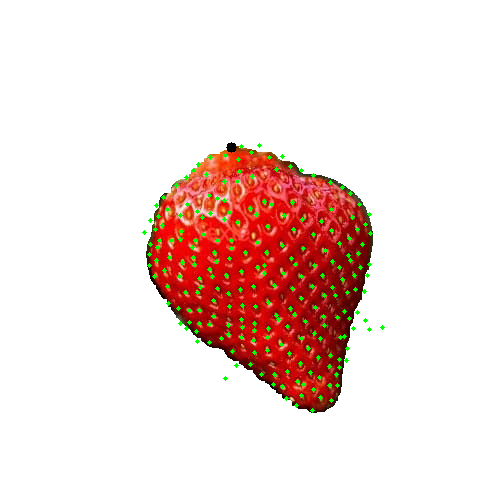

In [19]:
Image.fromarray(akenes_detecte_image)

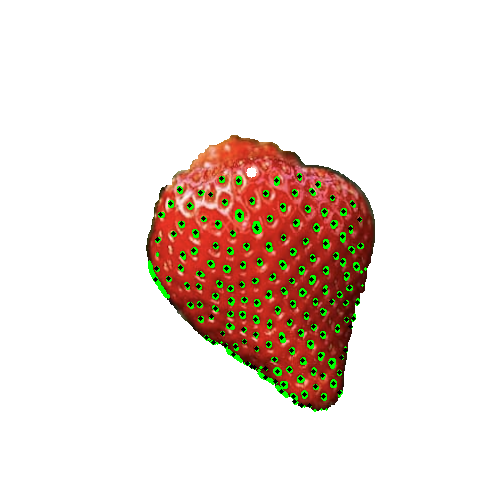

In [20]:
Image.fromarray(image_akenes_centre)

In [34]:
def euclidean_distance(coord1, coord2):
    return np.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

def calculate_confusion_matrix(coords1, coords2, threshold):
    true_positive = 0
    false_positive = 0
    false_negative = 0

    for coord1 in coords1:
        min_distance = float('inf')
        for coord2 in coords2:
            distance = euclidean_distance(coord1, coord2)
            if distance < min_distance:
                min_distance = distance
        if min_distance <= threshold:
            true_positive += 1
        else:
            false_positive += 1

    for coord2 in coords2:
        min_distance = float('inf')
        for coord1 in coords1:
            distance = euclidean_distance(coord1, coord2)
            if distance < min_distance:
                min_distance = distance
        if min_distance > threshold:
            false_negative += 1

    return true_positive, false_positive, false_negative


In [36]:
true_positive, false_positive, false_negative, = calculate_confusion_matrix(akene_sift_coords, akenes_coords, threshold=50)
print("True Positive:", true_positive)
print("False Positive:", false_positive)
print("False Negative:", false_negative)


True Positive: 226
False Positive: 0
False Negative: 0


: 

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def euclidean_distance(coord1, coord2):
    return np.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)


def calculate_confusion_matrix(coords1, coords2, threshold):
    true_positive = 0
    false_positive = 0
    false_negative = 0
    true_negative = 0

    for coord1 in coords1:
        min_distance = float('inf')
        for coord2 in coords2:
            distance = euclidean_distance(coord1, coord2)
            if distance < min_distance:
                min_distance = distance
        if min_distance <= threshold:
            true_positive += 1
        else:
            false_negative += 1

    for coord2 in coords2:
        min_distance = float('inf')
        for coord1 in coords1:
            distance = euclidean_distance(coord1, coord2)
            if distance < min_distance:
                min_distance = distance
        if min_distance > threshold:
            false_positive += 1

    # Assuming all negatives are outside coords1 and coords2 combined space
    total_negatives = (len(coords1) + len(coords2)) - (true_positive + false_positive + false_negative)
    true_negative = total_negatives

    return true_positive, false_positive, false_negative, true_negative

def generate_roc_curve(akene_sift_coords, akenes_coords):
    thresholds = range(51)  # Threshold values from 0 to 50
    tpr_values = []
    fpr_values = []

    for threshold in thresholds:
        true_positive, false_positive, false_negative, true_negative = calculate_confusion_matrix(akene_sift_coords, akenes_coords, threshold)
        
        # Calculate true positive rate (TPR)
        tpr = true_positive / (true_positive + false_negative) if (true_positive + false_negative) != 0 else 0
        tpr_values.append(tpr)
        
        # Calculate false positive rate (FPR)
        fpr = false_positive / (false_positive + true_negative) if (false_positive + true_negative) != 0 else 0
        fpr_values.append(fpr)

    # Plot ROC Curve (TPR vs FPR)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_values, tpr_values, marker='o', linestyle='-', label='ROC Curve')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.legend()
    plt.grid(True)
    plt.show()

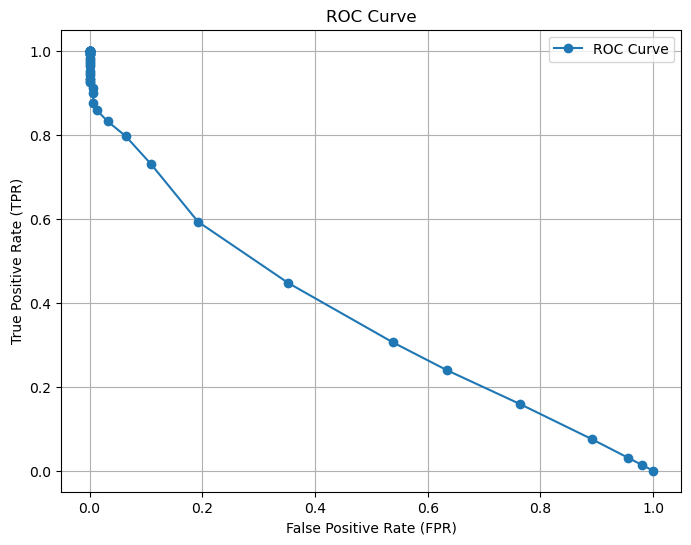

In [32]:
# Call the function to generate the ROC curve
generate_roc_curve(akene_sift_coords, akenes_coords)

In [25]:
def fraise_akene(img_path):
    image,coords,area=extract_akenes_sift(img_path)

    # Calculate pairwise distances between coordinates
    pairwise_distances = pdist(coords)
    average_distance = np.mean(pairwise_distances)
    return image, coords, area, average_distance

In [26]:
def fraise_akene_a_main(img_path):
    image,coords,area=extract_akenes_a_main(img_path)

    # Calculate pairwise distances between coordinates
    pairwise_distances = pdist(coords)
    average_distance = np.mean(pairwise_distances)
    return image, coords, area, average_distance

In [27]:
image, coords, area, average_distance=fraise_akene(img_path)
average_distance

115.42776866403072

In [28]:
image, coords, area, average_distance=fraise_akene_a_main(achenes_img)
average_distance

105.15752284411943

In [29]:
def analyse_fraise_akene(folder_path, output_csv):
    # Open the CSV file in write mode and create a CSV writer object
    with open(output_csv, mode='w', newline='') as file:
        writer = csv.writer(file)
        
        # Write the header row to the CSV file
        writer.writerow(['File Path', 'Coords', 'Area', 'Average Distance'])
        
        # Iterate over all files in the folder
        for filename in os.listdir(folder_path):
            # Check if the file is an image (you may need to adjust the condition based on your file types)
            if filename.endswith(".jpg") or filename.endswith(".png")or filename.endswith(".jpeg"):
                # Construct the full path to the image file
                image_path = os.path.join(folder_path, filename)
                image, coords, area, average_distance = fraise_akene(image_path)
                
                # Write the information for the current image to the CSV file
                writer.writerow([image_path, len(coords), area, average_distance])



In [30]:
#analyse_fraise_akene("/Users/insafbenlamari/Desktop/akenes/fraise", "/Users/insafbenlamari/Desktop/akenes/output.csv")
